# Dependencies loading

In [6]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Keras Tuner
import keras_tuner as kt

In [8]:
import warnings
warnings.filterwarnings('ignore')

# Data loading

In [11]:
fifa_url = "https://raw.githubusercontent.com/Niyetali/FIFA-Rating-Prediction/main/output"

# importing datasets
X_train = pd.read_csv(f"{fifa_url}/X_train_fe.csv", sep=',')
X_test = pd.read_csv(f"{fifa_url}/X_test_fe.csv", sep=',')
y_train = pd.read_csv(f"{fifa_url}/y_train.csv", sep=',')
y_test = pd.read_csv(f"{fifa_url}/y_test.csv", sep=',')

pd.set_option('display.max_columns', None)

# Print shapes of the datasets
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(14100, 42) (3525, 42)
(14100, 1) (3525, 1)


Let's drop the `Name` column:

In [13]:
X_train = X_train.drop(columns=['Name'], errors='ignore')
X_test = X_test.drop(columns=['Name'], errors='ignore')

In [14]:
X_train.head()

,Age,Nationality,Potential,Club,International Reputation,Weak Foot,Skill Moves,Body_Type,Attacking_Work_Rate,Defensive_Work_Rate,CB,CDM,CF,CM,GK,LAM,LB,LCB,LCM,LDM,LF,LM,LS,LW,LWB,RAM,RB,RCB,RCM,RDM,RES,RF,RM,RS,RW,RWB,ST,SUB,BMI,Age_Group,Value_to_Potential
0,22,60.146444,74,61.582005,1.0,3.0,4.0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,20.452885,0,14864.864865
1,16,61.014790,73,69.208020,1.0,3.0,1.0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,22.353715,2,3150.684932
2,35,66.254815,71,61.872308,2.0,2.0,3.0,1,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,23.620288,1,4577.464789
3,26,63.190972,70,63.101327,1.0,3.0,2.0,1,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23.589835,0,15714.285714
4,22,55.459091,62,59.455049,1.0,3.0,2.0,1,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,22.491349,0,2903.225806


# Feature Scaling

Feature scaling is crucial for FNNs because, unlike models like AdaBoost and XGBoost that are tree-based and inherently scale-invariant, neural networks rely on gradient-based optimization, which can become inefficient when features have different scales. By standardizing inputs, we ensure stable learning, faster convergence, and balanced contributions from all features during training.

In [17]:
# Scale features
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
X_train

array([[-2.43260062e-01, -8.33238517e-01,  4.64564578e-01, ...,
        -1.62409637e+00, -1.04548417e+00, -2.15643668e-01],
       [-1.53304454e+00, -6.06191975e-01,  3.11325432e-01, ...,
        -2.35985341e-01,  1.04904933e+00, -3.44780909e-01],
       [ 2.55127298e+00,  7.63916371e-01,  4.84713896e-03, ...,
         6.88950033e-01,  1.78258170e-03, -3.29052073e-01],
       ...,
       [-6.73188223e-01, -7.13344478e-01,  1.38399946e+00, ...,
         1.20889149e+00,  1.04904933e+00, -1.17693847e-01],
       [ 4.01632180e-01,  6.04072740e-03,  1.23076031e+00, ...,
         7.94943897e-01, -1.04548417e+00,  1.01593025e+00],
       [ 3.19616523e+00, -3.09519121e-01, -1.06782689e+00, ...,
         1.04092146e-01,  1.78258170e-03, -3.69179083e-01]])

In [19]:
X_test

array([[-1.10311638e+00, -3.31246998e-01, -1.48392007e-01, ...,
        -1.12764101e+00,  1.04904933e+00, -3.20456894e-01],
       [-4.58224142e-01, -2.05883987e+00, -1.52754432e+00, ...,
         8.00326464e-02,  1.04904933e+00, -3.41562581e-01],
       [ 8.31560341e-01,  7.63916371e-01,  1.99695604e+00, ...,
        -1.06619059e-01, -1.04548417e+00,  4.60753820e+00],
       ...,
       [-8.88152303e-01, -6.06191975e-01,  1.99695604e+00, ...,
         3.26572090e-01,  1.04904933e+00, -9.07900121e-02],
       [ 2.76623707e+00, -1.56134180e+00,  4.84713896e-03, ...,
         9.22045885e-01,  1.78258170e-03, -3.59329285e-01],
       [-4.58224142e-01,  1.92213363e+00,  4.64564578e-01, ...,
        -3.99546619e-01,  1.04904933e+00, -1.85849046e-01]])

# Baseline Model: Feedforward Neural Network (FNN)

Our baseline regression model is a simple yet effective starting point. It consists of a single dense layer with a linear activation, optimized using the default SGD optimizer and mean squared error loss function.

In [22]:
# Set random seed
seed = 56
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Initialize and build the model
model = Sequential([Dense(1, input_dim=X_train.shape[1], activation='linear')])

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.001), loss='mean_squared_error')

# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42 (168.00 B)

 Trainable params: 42 (168.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Train the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 2986.1028 - val_loss: 991.5043
Epoch 2/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - loss: 726.2557 - val_loss: 251.3673
Epoch 3/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - loss: 181.5854 - val_loss: 69.3703
Epoch 4/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step - loss: 48.6319 - val_loss: 23.9462
Epoch 5/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step - loss: 15.9199 - val_loss: 12.0715
Epoch 6/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step - loss: 7.7189 - val_loss: 8.5562
Epoch 7/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step - loss: 5.5667 - val_loss: 7.2107
Epoch 8/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - loss: 4.9384 - val_loss: 6.4936
Epoch 9/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step - loss: 4.7129 - val_loss: 6.0064
Epoch 10/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step - loss: 4.6060 - val_loss: 5.6357
Epoch 11/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - loss: 4.5419 - val_loss: 5.3415
Epoch 12/50
35

### Loss Curve

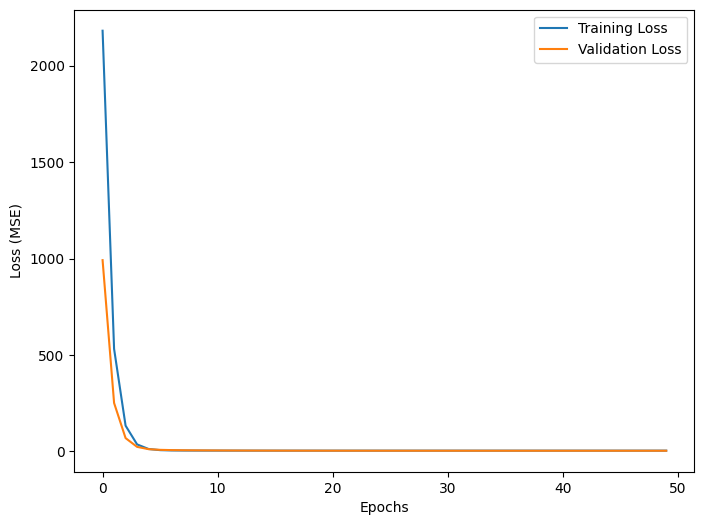

In [25]:
plt.figure(figsize=(8, 6))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [26]:
# Evaluate the Model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {loss}")

Test Loss (MSE): 4.49070930480957


The **loss curve** shows a smooth decrease in both training and validation loss, converging after a few epochs. This indicates the model is learning effectively and generalizing well, with no signs of overfitting or underfitting. The final **Test Loss (MSE)** of **4.491**, calculated on unseen data, confirms the model's strong performance and sets a solid baseline for further improvements. 🚀

In [28]:
# Predictions
y_pred = model.predict(X_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step


## Model Evaluation

In [36]:
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

# Calculate SMAPE
def smape(y_true, y_pred):
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

smape = smape(y_test, y_pred)

# Calculate Adjusted R²
n = len(y_test)
k = X_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Print metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape:.2f}%")
print(f"R² Score: {r2}")
print(f"Adjusted R² Score: {adjusted_r2}")

Mean Absolute Error (MAE): 1.6564757823944092
Mean Squared Error (MSE): 4.4907097816467285
Root Mean Squared Error (RMSE): 2.119129486757883
Mean Absolute Percentage Error (MAPE): 2.70%
Symmetric Mean Absolute Percentage Error (SMAPE): 2.69%
R² Score: 0.9297192692756653
Adjusted R² Score: 0.9288919623679139


---
#### **Results**

The model delivers strong and reliable predictions across key metrics:

- **MAE (Mean Absolute Error):** On average, predictions are off by just **1.66 units**.
- **MSE (Mean Squared Error):** The low MSE of **4.49** shows small and consistent errors.
- **RMSE (Root Mean Squared Error):** The RMSE of **2.12** represents the typical size of prediction errors, expressed in the same scale as     the target variable, making it easy to interpret.
- **MAPE (Mean Absolute Percentage Error):** Predictions are only **2.7%** off on average.
- **SMAPE (Symmetric Mean Absolute Percentage Error):** A SMAPE of **2.69%** confirms balanced performance for both under- and over-predictions.
- **R² Score:** The model explains **93% of the variance** in the data.
- **Adjusted R² Score:** The model generalizes well with an Adjusted R² of **0.929**.

These metrics show the model’s accuracy, consistency, and ability to generalize effectively. 

### Predicted vs Actual Values

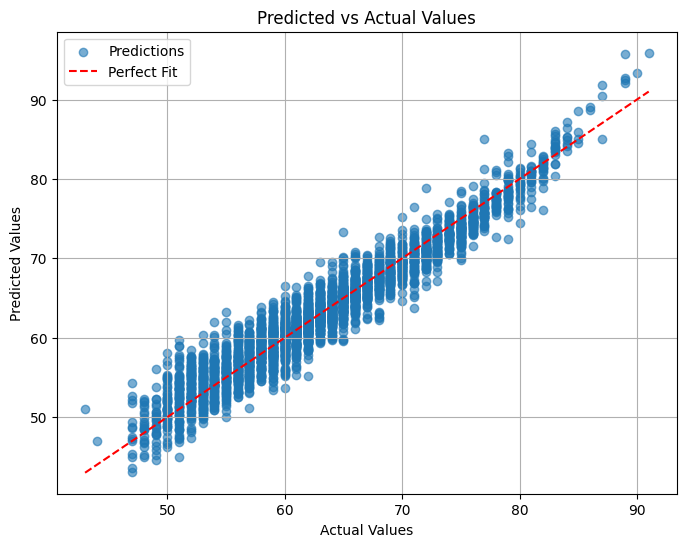

In [40]:
# Convert y_test and y_pred to 1D arrays with new names
actual_values = y_test.values.flatten()
predicted_values = y_pred.flatten()

# Predicted vs Actual Values Plot
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predicted_values, alpha=0.6, label='Predictions')
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

The points are close to the red "Perfect Fit" line, showing that the model is predicting well. Most predictions are right on target, with only a few small errors.

### Residuals Plot

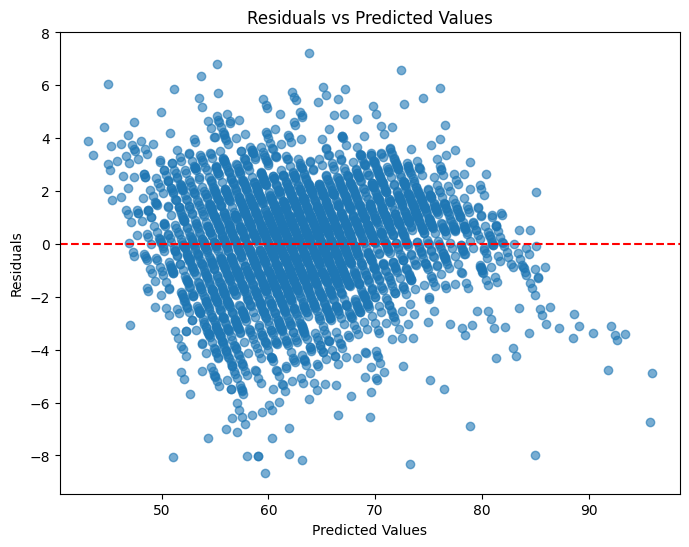

In [43]:
# Residuals
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6)

plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

The residuals are roughly evenly scattered around zero, showing unbiased predictions. The consistent spread indicates constant error variance, confirming the model captures the data's structure well. There are a few outliers though.

### Distribution of Residuals

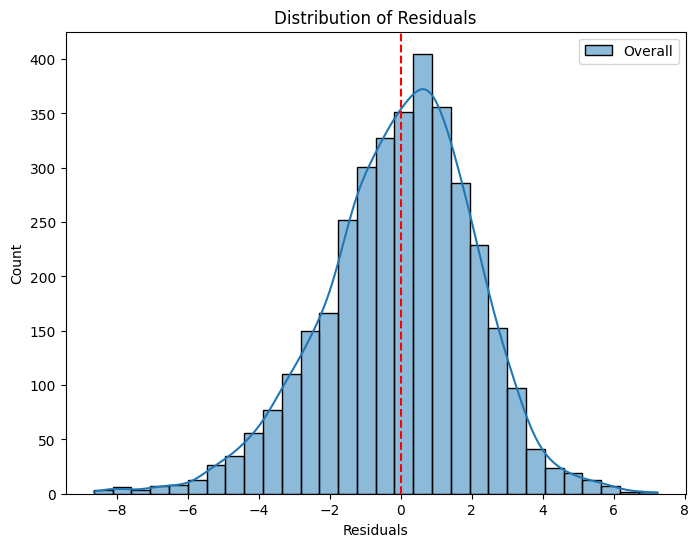

In [46]:
# Residual Distribution
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)

plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

The residuals for the **baseline model** follow a roughly normal distribution, with a slight negative skew indicating a tendency to under-predict in some cases. While this is a good starting point, there’s potential for improvement.

By applying **fine-tuning techniques** or transitioning to a more **complex FNN architecture**, we can address the skew and enhance the model’s predictive balance and accuracy.

### Error Distribution Chart

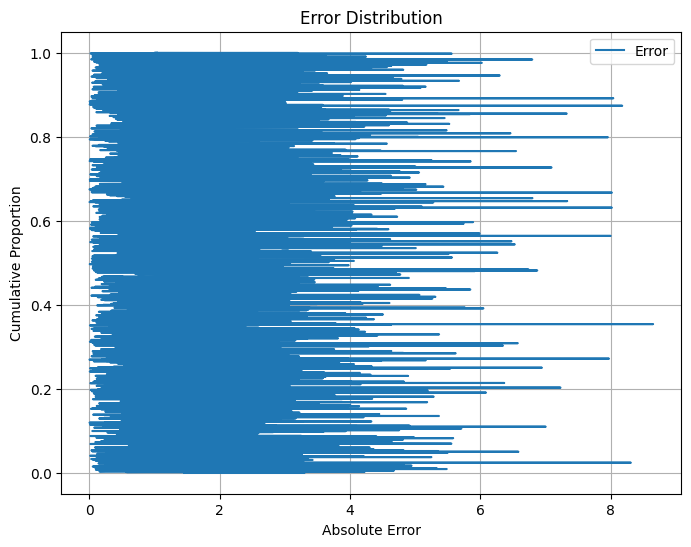

In [49]:
# Error Distribution
absolute_errors = np.abs(y_test - y_pred)
sorted_errors = np.sort(absolute_errors)
cumulative_errors = np.arange(len(sorted_errors)) / len(sorted_errors)

plt.figure(figsize=(8, 6))
plt.plot(absolute_errors, cumulative_errors, label='Error')
plt.xlabel('Absolute Error')
plt.ylabel('Cumulative Proportion')
plt.title('Error Distribution')
plt.grid(True)
plt.legend()
plt.show()

The Error Distribution Chart illustrates how the errors are spread, with most values relatively close to zero but some outliers. Overall, it's not bad, but there’s room for improvement. Let’s see if the MLP, with more layers, can refine these predictions!

# Advanced Model: Multilayer Perceptron (MLP)

## Model Overview

We’re taking our model to the next level! By introducing a few powerful enhancements, we’ll make it **smarter**, **faster**, and **better** at handling complex data. Here’s what we’re doing:

### 1. **Add More Layers & Neurons**
   - We’re increasing the model’s capacity by introducing **two hidden layers** with **128** and **64 neurons**, respectively.
   - This extra depth enables the model to capture **more complex patterns** and relationships in the data.
   - Unlike the baseline model’s **linear activation**, which can only learn straight-line relationships, the advanced model uses **ReLU**      in hidden layers. ReLU helps the model focus on important patterns by turning off less useful ones, allowing it to learn **more            flexible and complex patterns**.

### 2. **Use Regularization**
   - To keep overfitting at bay, we’ll apply **L2 regularization**. 
   - This encourages the model to focus on the **most important features**, avoiding excessive reliance on noise in the data.

### 3. **Batch Normalization**
   - **Batch normalization** will be added after each layer. Why? 
   - It helps stabilize and accelerate training by normalizing activations, making learning smoother.

### 4. **Introduce Dropout**
   - With **dropout**, we’ll randomly deactivate a fraction of neurons during training.
   - This helps the model **generalize better** and reduces overfitting by preventing dependency on specific neurons.

### 5. **Early Stopping**
   - To prevent wasting time and overfitting, we’ll use **early stopping**. 
   - The training process will halt automatically when the validation performance stops improving.

### 6. **Switch to Adam Optimizer**
   - We’re upgrading from **SGD** to the **Adam optimizer**.
   - Adam is faster, more adaptive, and perfect for handling the complexity of our improved architecture.

---

## Why These Changes Matter 🚀

These improvements make our model smarter, stronger, and more reliable.
- It can now **learn faster**, **adapt better**, and **generalize well** to new data.
- By addressing overfitting with regularization and dropout, it becomes more robust.
- The Adam optimizer and batch normalization work together to make the training process both **stable** and **efficient**.

Get ready for a model that goes above and beyond the baseline! 🌟

In [52]:
# Set random seed
seed = 56
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Initialize and build the model
def build_advanced_model(input_dim):
    model = Sequential()

    # First hidden layer with L2 regularization
    model.add(Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())  # Batch normalization for faster convergence
    model.add(Dropout(0.3))  # Dropout for regularization

    # Second hidden layer with L2 regularization
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(1, activation='linear'))

    # Compile the model with Adam optimizer
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    return model

# Create the model
model2 = build_advanced_model(X_train.shape[1])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history2 = model2.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

# Summary
model2.summary()

Epoch 1/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 597us/step - loss: 3841.4404 - val_loss: 2428.7522
Epoch 2/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 1771.0762 - val_loss: 278.1517
Epoch 3/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 187.8061 - val_loss: 13.8542
Epoch 4/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 63.9394 - val_loss: 9.2053
Epoch 5/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 57.5881 - val_loss: 8.3527
Epoch 6/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 53.9373 - val_loss: 7.6318
Epoch 7/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 48.8699 - val_loss: 6.8605
Epoch 8/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 46.4912 - val_loss: 5.8728
Epoch 9/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 43.5956 - val_loss: 5.7917
Epoch 10/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 41.6384 - val_loss: 5.4629
Epoch 11/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 40.5024 - val_loss: 5.55

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 128)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,629 (166.52 KB)

 Trainable params: 14,081 (55.00 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 28,164 (110.02 KB)

### Loss Curve

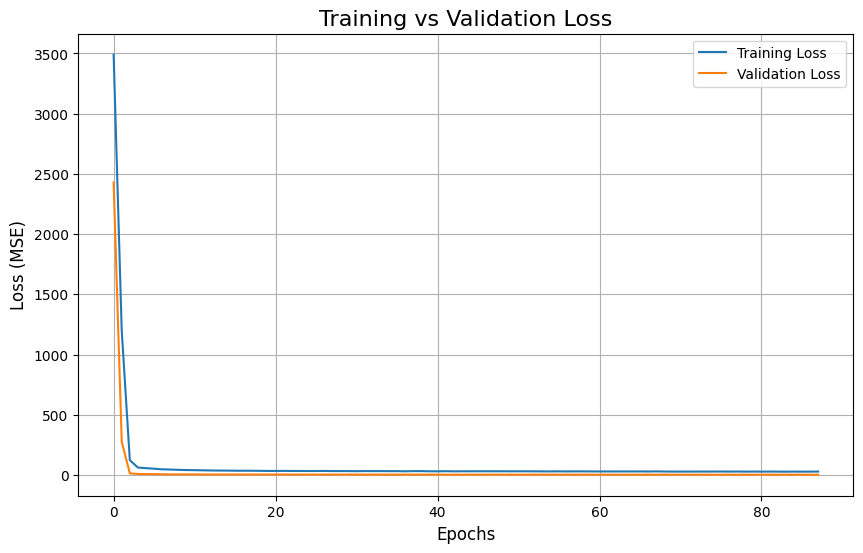

In [54]:
plt.figure(figsize=(10, 6))

plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training vs Validation Loss', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

The **loss curve** is similar to the baseline model, showing a quick drop in both **training** and **validation loss**, with the losses stabilizing afterward. This indicates the model is **learning effectively** and **generalizing well** without significant overfitting.

In [56]:
# Predictions
y_pred2 = model2.predict(X_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step


## Model Evaluation

In [58]:
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred2)
mse = mean_squared_error(y_test, y_pred2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred2) / y_test)) * 100
r2 = r2_score(y_test, y_pred2)

# Calculate SMAPE
def smape(y_true, y_pred):
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

smape = smape(y_test, y_pred2)

# Calculate Adjusted R²
n = len(y_test)
k = X_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Print metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape:.2f}%")
print(f"R² Score: {r2}")
print(f"Adjusted R² Score: {adjusted_r2}")

Mean Absolute Error (MAE): 1.1620891094207764
Mean Squared Error (MSE): 2.402143716812134
Root Mean Squared Error (RMSE): 1.5498850656781404
Mean Absolute Percentage Error (MAPE): 1.89%
Symmetric Mean Absolute Percentage Error (SMAPE): 1.89%
R² Score: 0.9624058604240417
Adjusted R² Score: 0.9619633224617637


---
### Results

The results from this model show clear improvements over the baseline model:

- **MAE:** Decreased from **1.66** to **1.16**, indicating predictions are closer to the actual values.
- **MSE:** Reduced significantly from **4.49** to **2.40**, highlighting fewer large errors.
- **RMSE:** Dropped from **2.12** to **1.55**, confirming lower average prediction errors.
- **MAPE and SMAPE:** Improved from **2.7%** and **2.69%** to **1.89%**, reflecting higher relative accuracy with balanced under- and over-predictions.
- **R² Score:** Increased from **0.93** to **0.96**, meaning the model now explains 96% of the variance in the data.
- **Adjusted R²:** Also improved from **0.93** to **0.96**, indicating the enhancements generalize well without overfitting.

This comparison shows the impact of a more advanced architecture, showing stronger predictive accuracy and consistency across all metrics. Added complexity has clearly paid off! 🚀

### Predicted vs Actual Values

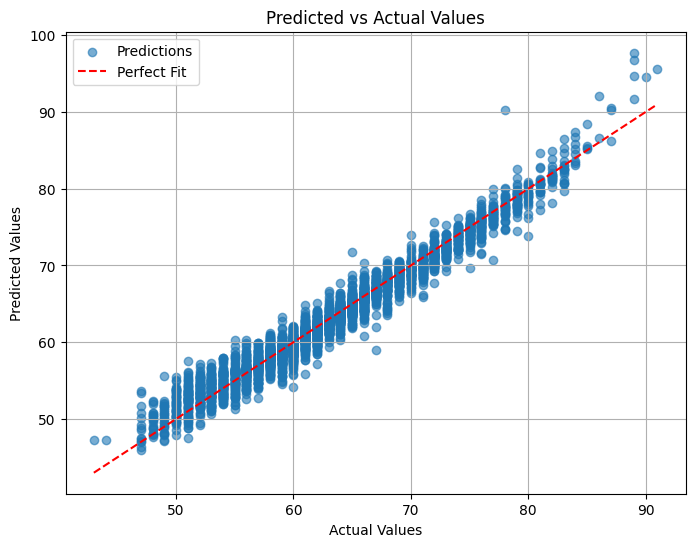

In [61]:
# Convert y_test and y_pred2 to 1D arrays
actual_values = y_test.values.flatten()
predicted_values = y_pred2.flatten()

# Predicted vs Actual Values Plot
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predicted_values, alpha=0.6, label='Predictions')
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

The **Predicted vs Actual** plot shows strong alignment, with predictions even closer to the **Perfect Fit line**, improving on the baseline model.

### Residuals Plot

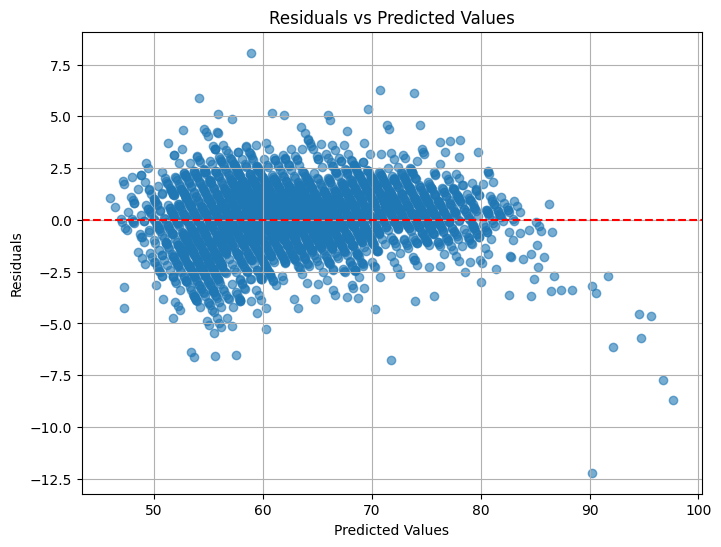

In [64]:
# Residuals
residuals = y_test - y_pred2

plt.figure(figsize=(8, 6))
plt.scatter(y_pred2, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.grid(True)
plt.show()

The **baseline model** had some larger errors and a random spread of residuals, but the **advanced model** has improved, with more evenly distributed residuals and fewer big prediction blunders!

### Distribution of Residuals

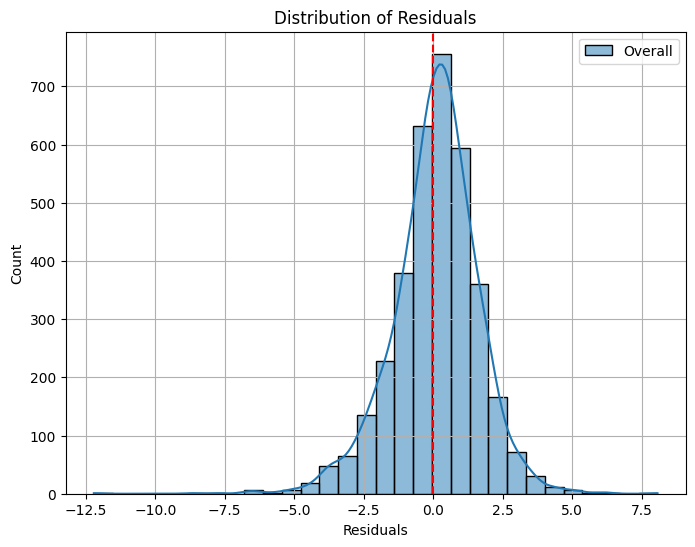

In [67]:
# Residual Distribution
residuals = y_test - y_pred2

plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='steelblue')

plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.grid(True)
plt.show()

The **advanced model** has a more balanced residual distribution centered around zero, while the **baseline model** was skewed towards the **negative side**, showing more large errors. The advanced model clearly outperforms in consistency and precision!

### Error Distribution Chart

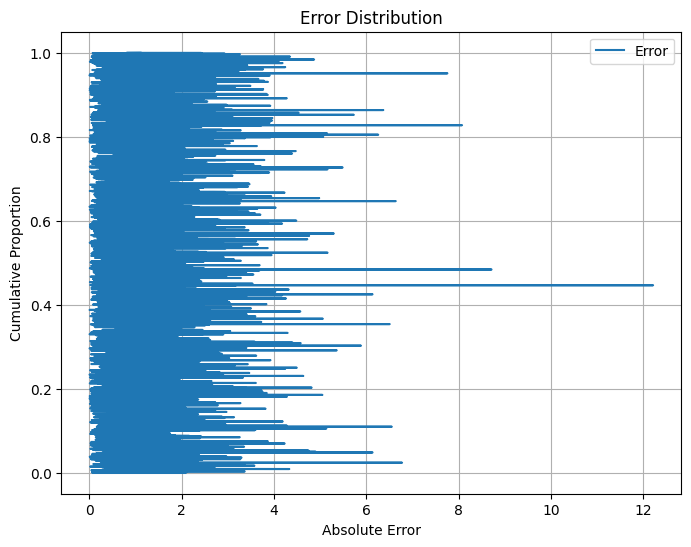

In [70]:
# Cumulative Error Distribution
absolute_errors = np.abs(y_test - y_pred2)
sorted_errors = np.sort(absolute_errors)
cumulative_errors = np.arange(len(sorted_errors)) / len(sorted_errors)

plt.figure(figsize=(8, 6))
plt.plot(absolute_errors, cumulative_errors, label='Error')
plt.xlabel('Absolute Error')
plt.ylabel('Cumulative Proportion')
plt.title('Error Distribution')
plt.grid(True)
plt.legend()

This **Error Distribution Chart** looks much better—most errors are small and close to zero. But hey, there are still a couple of unwanted bees buzzing around (those outliers 😤😤).

# Advanced Model on Steroids: MLP with 5 Layers

## What's New in This Model?

We’ve pushed the limits of our MLP with exciting new changes to make it smarter, deeper, and more robust:

### 1. **Deeper Architecture**
- Added **5 hidden layers** with up to **1024 neurons**, giving the model more power to learn complex patterns. The number of neurons varies across layers, starting with more neurons (e.g., **1024**) in the middle layers to capture high-level features and gradually reducing neurons (e.g., **512** and **256**) in later layers. This progressive reduction helps the model focus on refining the most important patterns while maintaining computational efficiency.

### 2. **Leaky ReLU Activation**
- Switched from **ReLU** to **Leaky ReLU**, which fixes the issue where some neurons stop working and learning completely. Leaky ReLU keeps them active by letting small values pass through, making the learning process smoother.

### 3. **Balanced Regularization**
- Combined **L1 and L2 regularization** with lower strength (`0.001` each) to prevent overfitting and allow the model to focus on the most critical features.

### 4. **Refined Dropout Rates**
- Dropout rates were fine-tuned:
  - **30%** for earlier layers to retain more information in initial training phases.
  - **20%** for later layers to maintain stability and focus on essential features.

### 5. **Dynamic Learning Rate Decay**
- Introduced a **learning rate scheduler** to reduce the learning rate after **25 epochs**, allowing for finer adjustments during training.

### 6. **Gradient Clipping**
- Introduced **gradient clipping**, a technique that limits the size of gradients during backpropagation. This prevents the issue of      **exploding gradients**, which can destabilize training in deeper networks, ensuring the model learns effectively without major fluctuations.

### 7. **Smaller Batch Size**
- Reduced the batch size to **16**, which allows the model to update weights more frequently. This finer-grained learning approach can be particularly effective for small or medium datasets as in our case, leading to more precise adjustments and better performance, especially when dealing with complex data.

---

## Why These Changes Matter??

These enhancements give the model:
- The capacity to handle **super complex data** with ease.
- **Better generalization** by preventing overfitting through advanced regularization techniques.
- **Smoother and faster training** with batch normalization, learning rate decay, and gradient clipping.

This model isn’t just advanced—it’s a powerhouse! 🎉

In [73]:
# Set random seed
seed = 56
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Learning rate decay function
def scheduler(epoch, lr):
    # Decay learning rate earlier, every 25 epochs
    if epoch > 25:
        lr = lr * 0.5
    return lr

# Initialize and build the model
def build_very_advanced_model(input_dim):
    model = Sequential()

    # First hidden layer with L1_L2 regularization
    model.add(Dense(512, input_dim=input_dim, kernel_regularizer=l1_l2(l1=0.001, l2=0.001), 
                    kernel_initializer='he_normal'))
    model.add(LeakyReLU(alpha=0.1))  # Leaky ReLU for better gradient flow
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Second hidden layer
    model.add(Dense(1024, kernel_regularizer=l1_l2(l1=0.001, l2=0.001), kernel_initializer='he_normal'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Third hidden layer
    model.add(Dense(1024, kernel_regularizer=l1_l2(l1=0.001, l2=0.001), kernel_initializer='he_normal'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))  # Reduced dropout rate for later layers

    # Fourth hidden layer
    model.add(Dense(512, kernel_regularizer=l1_l2(l1=0.001, l2=0.001), kernel_initializer='he_normal'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Fifth hidden layer
    model.add(Dense(256, kernel_regularizer=l1_l2(l1=0.001, l2=0.001), kernel_initializer='he_normal'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(1, activation='linear'))

    # Compile the model with Adam optimizer and gradient clipping
    model.compile(optimizer=Adam(learning_rate=0.002, clipnorm=1.0), loss='mean_squared_error')

    return model

# Create the model
model3 = build_very_advanced_model(X_train.shape[1])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate scheduler callback
lr_scheduler = LearningRateScheduler(scheduler)

# Train the model
history3 = model3.fit(X_train, y_train, epochs=100, batch_size=16,  # Smaller batch size
                      validation_split=0.2, verbose=1, 
                      callbacks=[early_stopping, lr_scheduler])

# Model summary
model3.summary()

Epoch 1/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 2108.3059 - val_loss: 62.4629 - learning_rate: 0.0020
Epoch 2/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 76.9277 - val_loss: 41.9793 - learning_rate: 0.0020
Epoch 3/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 56.0542 - val_loss: 39.4142 - learning_rate: 0.0020
Epoch 4/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 49.8742 - val_loss: 32.3768 - learning_rate: 0.0020
Epoch 5/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 45.2202 - val_loss: 32.2605 - learning_rate: 0.0020
Epoch 6/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 40.4825 - val_loss: 25.3348 - learning_rate: 0.0020
Epoch 7/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 37.7017 - val_loss: 45.0812 - learning_rate: 0.0020
Epoch 8/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 34.2828 - val_loss: 24.8697 - learning_rate: 0.0020
Epoch 9/100
705/705 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 32.8091 - val_loss: 23.1

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 512)            │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,785,029 (25.88 MB)

 Trainable params: 2,259,457 (8.62 MB)

 Non-trainable params: 6,656 (26.00 KB)

 Optimizer params: 4,518,916 (17.24 MB)

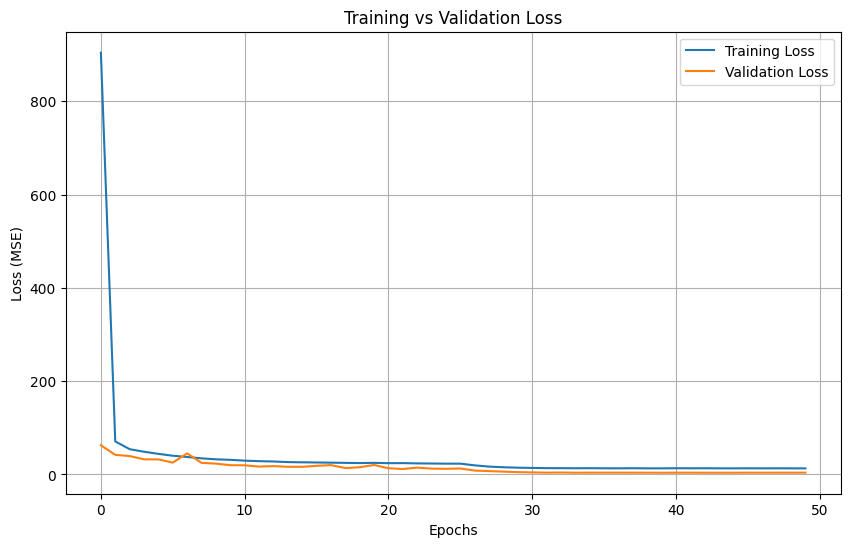

In [74]:
plt.figure(figsize=(10, 6))

plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

It reaches a low loss quicker and maintains stability.

In [76]:
y_pred3 = model3.predict(X_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


## Model Evaluation

In [78]:
# Calculate the metrics
mae = mean_absolute_error(y_test, y_pred3)
mse = mean_squared_error(y_test, y_pred3)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred3)
mape = np.mean(np.abs((y_test - y_pred3) / y_test)) * 100

# Calculate SMAPE
def smape(y_true, y_pred):
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

smape_value = smape(y_test, y_pred3)

# Adjusted R²
n = len(y_test)
k = X_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape_value:.2f}%")
print(f"R² Score: {r2}")
print(f"Adjusted R² Score: {adjusted_r2}")

Mean Absolute Error (MAE): 1.1266247034072876
Mean Squared Error (MSE): 2.219985246658325
Root Mean Squared Error (RMSE): 1.4899614916696087
Mean Absolute Percentage Error (MAPE): 1.86%
Symmetric Mean Absolute Percentage Error (SMAPE): 1.84%
R² Score: 0.9652566909790039
Adjusted R² Score: 0.9648477114585156


**Model 3** slightly outperforms **Model 2** across all metrics, with lower errors **(MAE, MSE, RMSE, MAPE, and SMAPE)** and a higher **R²** and **Adjusted R²**. While the improvement isn't massive, it demonstrates the benefit of a deeper and more refined architecture. The difference in SMAPE (1.84% vs. 1.89%) confirms Model 3's predictions are marginally closer to the actual values, showing smoother learning and better generalization.

### Predicted vs Actual Values

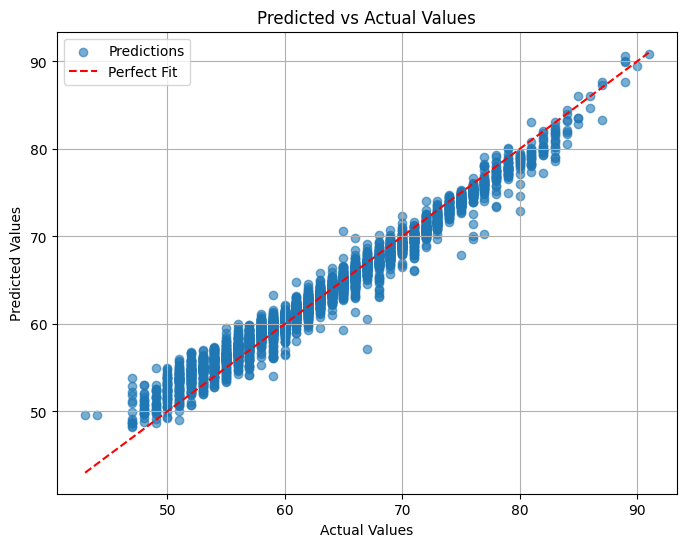

In [81]:
# Convert y_test and y_pred3 to 1D arrays
actual_values = y_test.values.flatten()
predicted_values = y_pred3.flatten()

# Predicted vs Actual Values Plot
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predicted_values, alpha=0.6, label='Predictions')
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

The results are nearly identical to the second model.

### Residuals Plot

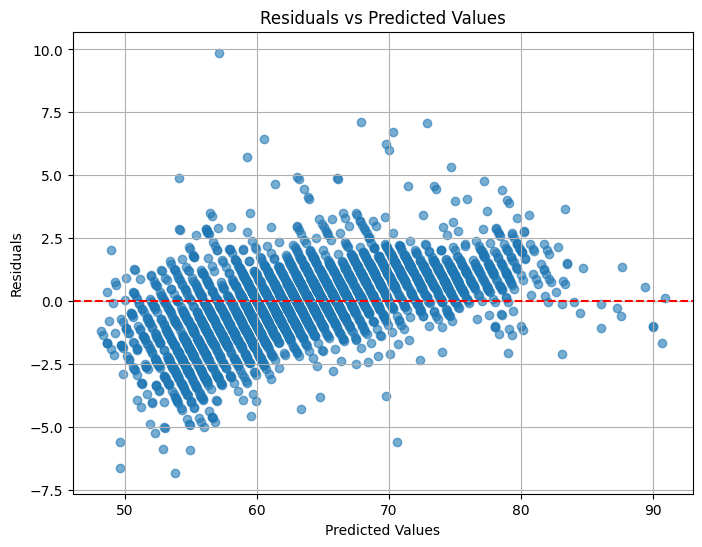

In [84]:
# Residuals
residuals = y_test - y_pred3

plt.figure(figsize=(8, 6))
plt.scatter(y_pred3, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.grid(True)
plt.show()

Residuals are slightly less condensed around 0, showing minor variations in prediction accuracy while maintaining a centered distribution.

### Distribution of Residuals

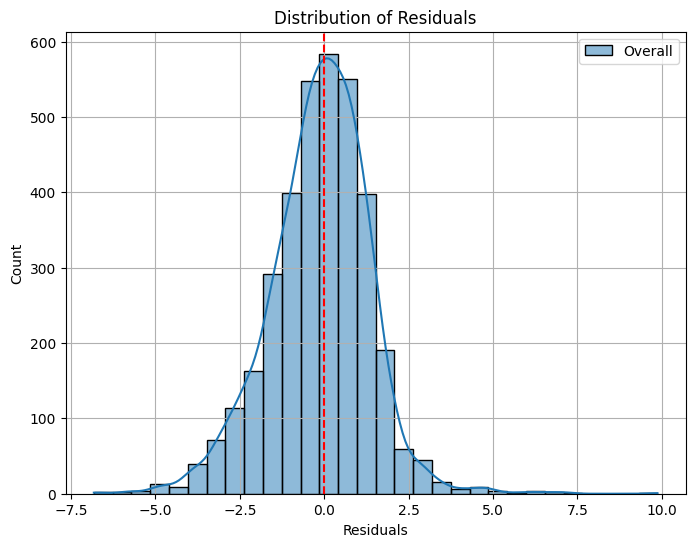

In [87]:
# Residual Distribution
residuals = y_test - y_pred3

plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='steelblue')

plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.grid(True)
plt.show()

Residuals show a near-normal distribution, much like Model 2, indicating balanced predictions with minimal skew.

### Error Distribution Chart

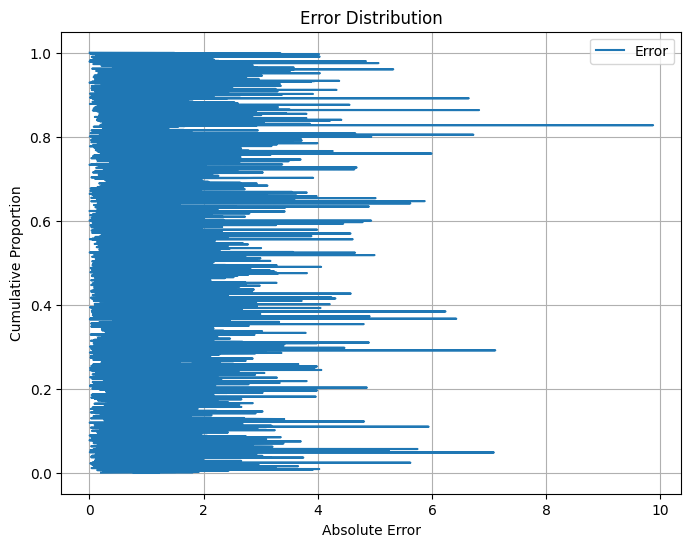

In [93]:
# Cumulative Error Distribution
absolute_errors = np.abs(y_test - y_pred3)
sorted_errors = np.sort(absolute_errors)
cumulative_errors = np.arange(len(sorted_errors)) / len(sorted_errors)

plt.figure(figsize=(8, 6))
plt.plot(absolute_errors, cumulative_errors, label='Error')
plt.xlabel('Absolute Error')
plt.ylabel('Cumulative Proportion')
plt.title('Error Distribution')
plt.grid(True)
plt.legend()

Feels like déjà vu with Model 2—this plot looks almost the same, with error patterns nearly identical! 🤔

# Hyperparameter tunning

Although **Model 3** showed slightly better performance than **Model 2**, the improvements are marginal and don’t justify the added complexity and computational cost. Model 3’s deeper architecture and extra enhancements bring diminishing returns, making it overkill for our needs. 

**Model 2**, on the other hand, is already delivering **amazing results** with a much simpler design. Its balance of performance and efficiency makes it the perfect candidate for hyperparameter tuning. By refining its parameters, we can further optimize its accuracy without the unnecessary overhead of Model 3’s additional layers and complexity.

Sometimes, **simpler is smarter**! 🚀

In [132]:
# Set random seed
seed = 56
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Define the model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()

    # First hidden layer
    model.add(Dense(
        units=hp.Int('units_layer1', min_value=64, max_value=256, step=64),
        input_dim=X_train.shape[1],
        activation='relu',
        kernel_regularizer=l2(hp.Float('l2_layer1', min_value=0.0001, max_value=0.01, sampling='log'))
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_layer1', min_value=0.2, max_value=0.5, step=0.1)))

    # Second hidden layer
    model.add(Dense(
        units=hp.Int('units_layer2', min_value=32, max_value=128, step=32),
        activation='relu',
        kernel_regularizer=l2(hp.Float('l2_layer2', min_value=0.0001, max_value=0.01, sampling='log'))
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_layer2', min_value=0.2, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='log')),
        loss='mean_squared_error'
    )
    return model

# Initialize Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=30,  # Number of different hyperparameter combinations to try
    executions_per_trial=2,  # Number of models to train for each trial
    directory='my_dir',
    project_name='model2_hyperparameter_tuning'
)

# Run the search
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, verbose=1, batch_size=32)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build and train the model with the best hyperparameters
model2 = tuner.hypermodel.build(best_hps)
history2 = model2.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32, verbose=1)

# Summary of the tuned model
model2.summary()

Reloading Tuner from my_dir/model2_hyperparameter_tuning/tuner0.json
Epoch 1/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2292.8271 - val_loss: 67.5908
Epoch 2/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30.5703 - val_loss: 9.3393
Epoch 3/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22.9026 - val_loss: 11.9442
Epoch 4/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.9447 - val_loss: 5.0838
Epoch 5/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15.7177 - val_loss: 5.0866
Epoch 6/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14.4853 - val_loss: 5.7932
Epoch 7/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13.1663 - val_loss: 3.7268
Epoch 8/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.6056 - val_loss: 3.6616
Epoch 9/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.5332 - val_loss: 3.2858
Epoch 10/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10.9044 - val_loss: 4.4095
Epoch 11/100
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 1

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 384)            │        16,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 384)            │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 288)            │       110,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 288)            │         1,152 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 387,269 (1.48 MB)

 Trainable params: 128,641 (502.50 KB)

 Non-trainable params: 1,344 (5.25 KB)

 Optimizer params: 257,284 (1005.02 KB)

In [134]:
print(f"""
The optimal number of units in the first hidden layer is {best_hps.get('units_layer1')}.
The optimal number of units in the second hidden layer is {best_hps.get('units_layer2')}.
The optimal dropout rates are {best_hps.get('dropout_layer1')} and {best_hps.get('dropout_layer2')}.
The optimal L2 regularization strengths are {best_hps.get('l2_layer1')} and {best_hps.get('l2_layer2')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
""")


The optimal number of units in the first hidden layer is 384.
The optimal number of units in the second hidden layer is 288.
The optimal dropout rates are 0.30000000000000004 and 0.2.
The optimal L2 regularization strengths are 0.00013599217213076663 and 0.00022787424864518472.
The optimal learning rate is 0.0026338806701157935.



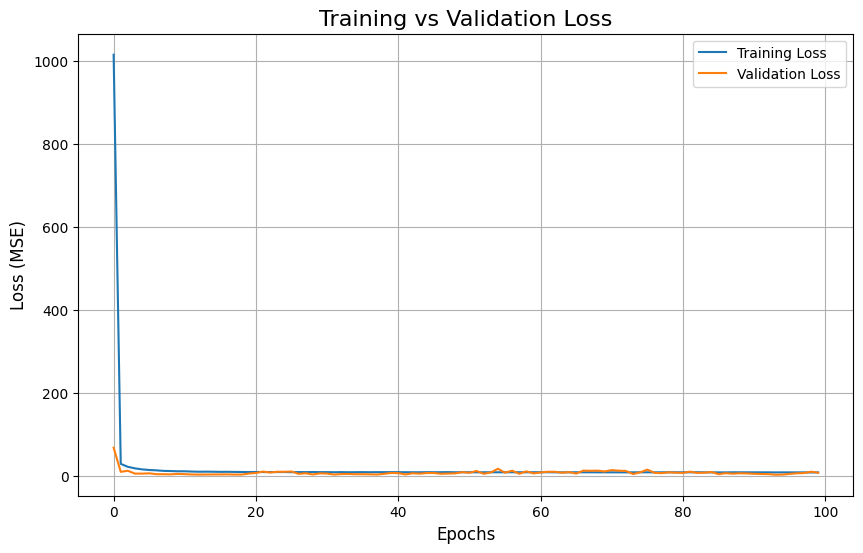

In [136]:
plt.figure(figsize=(10, 6))

plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training vs Validation Loss', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

It achieves lower loss faster and stays more stable compared to Model 2 without hyperparameter tuning.

In [139]:
# Predictions
y_pred2 = model2.predict(X_test)

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step


## Model Evaluation

In [142]:
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred2)
mse = mean_squared_error(y_test, y_pred2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred2) / y_test)) * 100
r2 = r2_score(y_test, y_pred2)

# Calculate SMAPE
def smape(y_true, y_pred):
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

smape = smape(y_test, y_pred2)

# Calculate Adjusted R²
n = len(y_test)
k = X_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Print metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape:.2f}%")
print(f"R² Score: {r2}")
print(f"Adjusted R² Score: {adjusted_r2}")

Mean Absolute Error (MAE): 0.9014737606048584
Mean Squared Error (MSE): 1.7014557123184204
Root Mean Squared Error (RMSE): 1.3043986017772407
Mean Absolute Percentage Error (MAPE): 1.48%
Symmetric Mean Absolute Percentage Error (SMAPE): 1.47%
R² Score: 0.9733718037605286
Adjusted R² Score: 0.9730583509767736


Hyperparameter tuning improved **Model 2** across all metrics, with **MAE** dropping from **1.16** to **0.90** and **MSE** decreasing from **2.40** to **1.70**. The model now explains **97.3%** of the variance (up from **96.2%**) while making more accurate and consistent predictions. A clear win for precision and performance! 🚀

### Predicted vs Actual Values

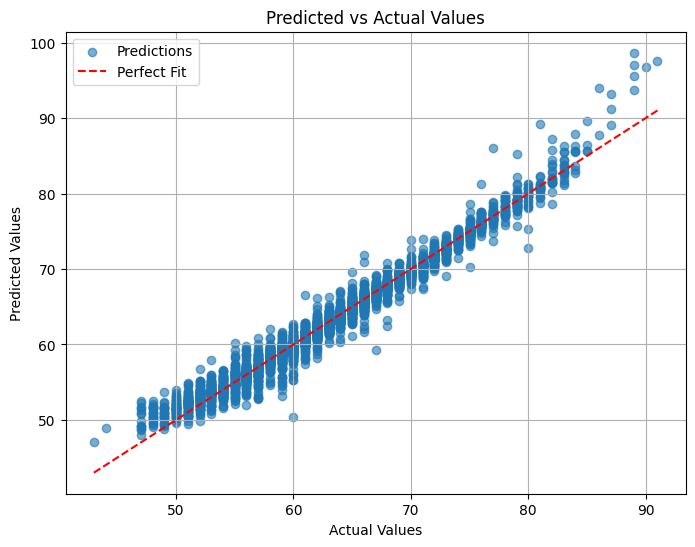

In [146]:
# Convert y_test and y_pred2 to 1D arrays
actual_values = y_test.values.flatten()
predicted_values = y_pred2.flatten()

# Predicted vs Actual Values Plot
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predicted_values, alpha=0.6, label='Predictions')
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

It's hard to notice a big difference here, to be fair.

### Residuals Plot

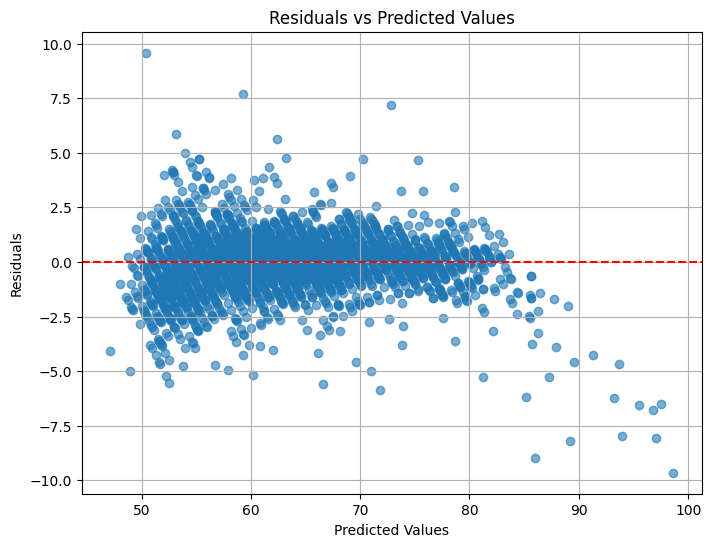

In [150]:
# Residuals
residuals = y_test - y_pred2

plt.figure(figsize=(8, 6))
plt.scatter(y_pred2, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.grid(True)
plt.show()

Same !

### Distribution of Residuals

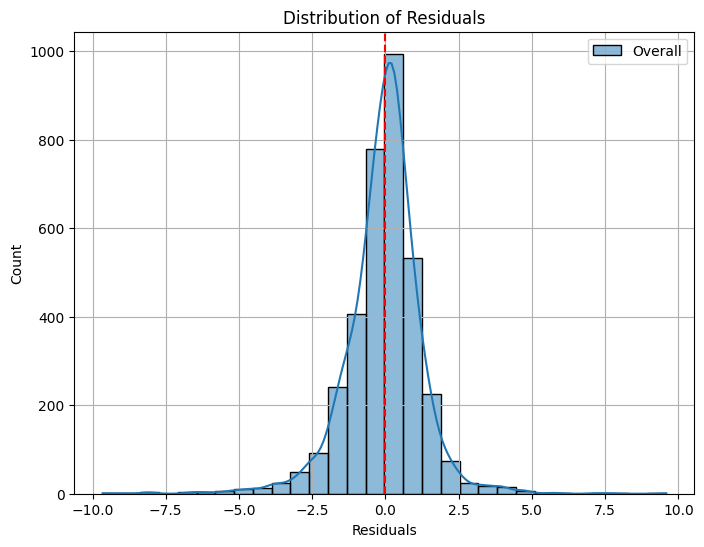

In [154]:
# Residual Distribution
residuals = y_test - y_pred2

plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='steelblue')

plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.grid(True)
plt.show()

It looks almost like a perfect normal distribution.

### Error Distribution

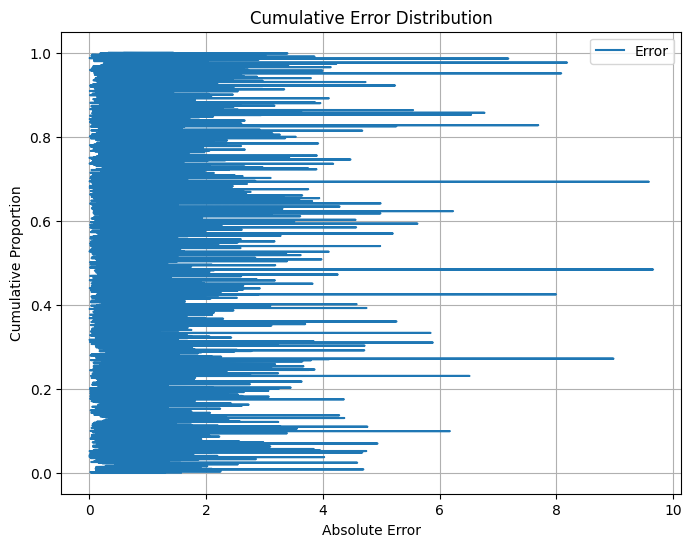

In [158]:
# Cumulative Error Distribution
absolute_errors = np.abs(y_test - y_pred2)
sorted_errors = np.sort(absolute_errors)
cumulative_errors = np.arange(len(sorted_errors)) / len(sorted_errors)

plt.figure(figsize=(8, 6))
plt.plot(absolute_errors, cumulative_errors, label='Error')
plt.xlabel('Absolute Error')
plt.ylabel('Cumulative Proportion')
plt.title('Cumulative Error Distribution')
plt.grid(True)
plt.legend()

# Feature Importance

Now, we’ll dive into **permutation importance** to see which features are truly driving our model’s predictions. It’s a simple but powerful technique that helps us understand which inputs are making the biggest impact! 🔍

In [162]:
# Compute permutation importance directly using Keras model
perm_importance = permutation_importance(
    estimator=model2,  # Use the Keras model directly
    X=X_test,
    y=y_test,
    scoring="neg_mean_squared_error",  # Specify the scoring metric
    n_repeats=10,  # Number of shuffles per feature
    random_state=56
)

# Display feature importance
for i, score in enumerate(perm_importance.importances_mean):
    print(f"Feature {i}: Importance = {score:.4f}")

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step
111/111 ━━━

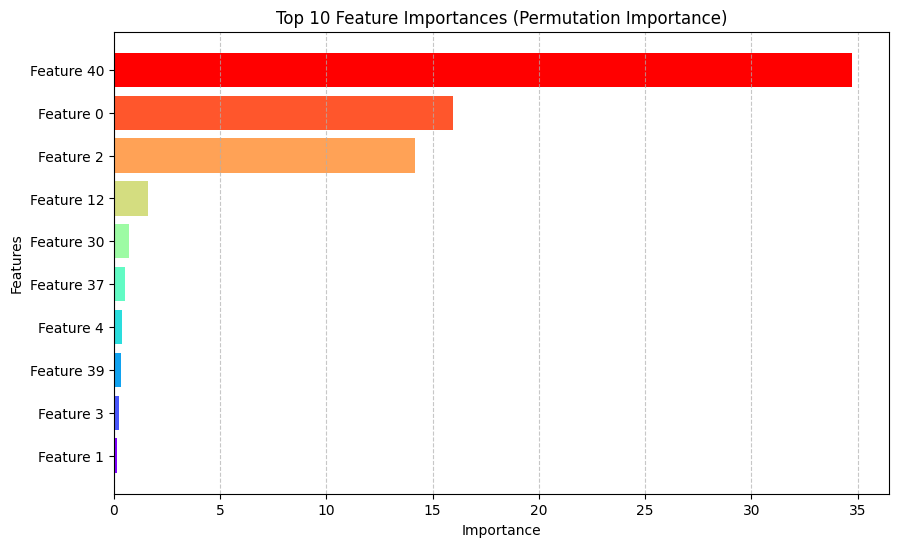

In [164]:
# Extract and sort feature importances
importances = perm_importance.importances_mean
top_10_indices = importances.argsort()[-10:]  # Indices of top 10 features
top_10_importances = importances[top_10_indices]
top_10_feature_names = [f"Feature {i}" for i in top_10_indices]

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
colors = plt.cm.rainbow(np.linspace(0, 1, len(top_10_importances)))  # Rainbow colors
plt.barh(top_10_feature_names, top_10_importances, color=colors)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 10 Feature Importances (Permutation Importance)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Out of 41 features, the model is mainly driven by just **three**: **`Age`**, **`Potential`**, and **`Value_to_Potential`**. What's even more interesting is that **Value_to_Potential** almost doubles the importance of the other two, clearly standing out as the most influential factor in the model! 📊

This feature was created by us during **feature engineering**, combining **`Value`** and **`Potential`**.

## Final Model Results

In [168]:
# Metrics data
metrics = {"Metric": ["MAE", "MSE", "RMSE", "MAPE", "SMAPE", "R²", "Adj. R²"],
            "Value": [mae, mse, rmse, mape, smape ,r2, adjusted_r2]}

# Create a DataFrame
metrics = pd.DataFrame(metrics)

metrics

,Metric,Value
0,MAE,0.901474
1,MSE,1.701456
2,RMSE,1.304399
3,MAPE,1.475572
4,SMAPE,1.470589
5,R²,0.973372
6,Adj. R²,0.973058


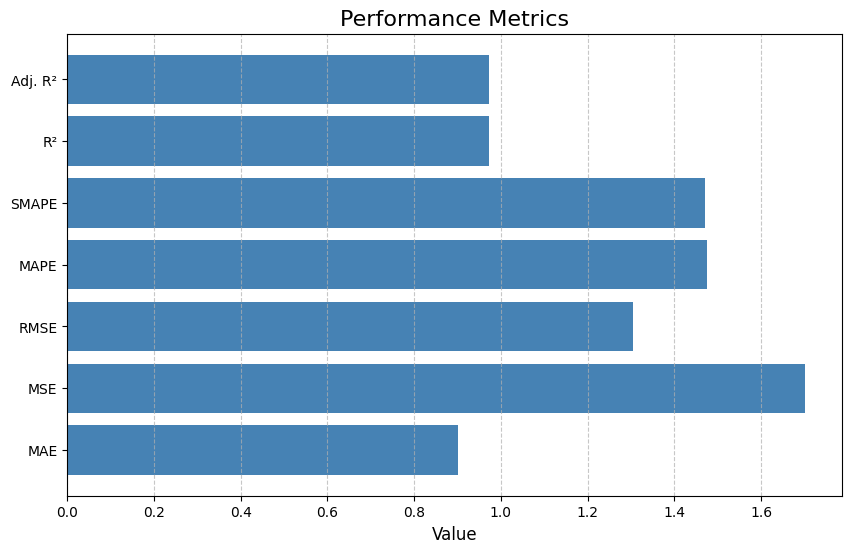

In [174]:
# Plotting the metrics as a bar chart
plt.figure(figsize=(10, 6))
plt.barh(metrics['Metric'], metrics['Value'], color='steelblue')
plt.xlabel('Value', fontsize=12)
plt.title('Performance Metrics', fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### A Strong Performer! 🚀

Our final model is delivering impressive results across all metrics. The **MAE** is just **0.90**, showing high accuracy, while the **MSE** is low at **1.70**, indicating minimal large errors. The **RMSE** of **1.30** keeps predictions close to the truth, and with a **MAPE**/**SMAPE** of just **1.47**, the model is tightly aligned with actual values. The **R²** score of **97.3%** means the model explains almost all of the variance in the data, and the **Adjusted R²** of **97.3%** highlights its strong ability to generalize to new data. Plus, it’s **quick** and **computationally efficient**, making it both powerful and practical. In short, our model is sharp, reliable, and ready to tackle complex prediction tasks! 🎯